In [1]:
import numpy as np

In [2]:
images_url = "./CUB_200_2011/images.txt"
train_test_split_url = "./CUB_200_2011/train_test_split.txt"
classes_url = "./CUB_200_2011/classes.txt"
image_class_labels_url = "./CUB_200_2011/image_class_labels.txt"

Loading .txt file

In [3]:
image = np.genfromtxt(images_url , delimiter=' ', dtype=str) #<image_id> <image_name>
image = {int(row[0]): "CUB_200_2011/images/"+row[1] for row in image}

train_test_split = np.genfromtxt(train_test_split_url, delimiter=" ", dtype=str) #<image_id> <is_training_image>
train_test_split = {int(row[0]): int(row[1]) for row in train_test_split}

classes = np.genfromtxt(classes_url, delimiter=" ", dtype=str) #<class_id> <class_name>
classes = {int(row[0]): row[1] for row in classes}

image_class_labels = np.genfromtxt(image_class_labels_url, delimiter=" ", dtype=str).astype(int) #<image_id> <class_id>
image_class_labels = {int(row[0]): int(row[1]) for row in image_class_labels}

<table>
    <tr>
        <td>image</td>
        <td>&lt;image_id&gt; &lt;image_name&gt;</td>
    </tr>
    <tr>
        <td>train_test_split</td>
        <td>&lt;image_id&gt; &lt;is_training_image&gt;</td>
    </tr>
    <tr>
        <td>classes</td>
        <td>&lt;class_id&gt; &lt;class_name&gt;</td>
    </tr>
    <tr>
        <td>image_class_labels</td>
        <td>&lt;image_id&gt; &lt;class_id&gt;</td>
    </tr>
</table>

In [4]:
row = 5
print(row, image[row])
print(row, train_test_split[row])
print(row, classes[row])
print(row, image_class_labels[row])

5 CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg
5 1
5 005.Crested_Auklet
5 1


In [5]:
# image_train = {key: value for key, value in  train_test_split.items() if value == 1}
# image_test = {key: value for key, value in  train_test_split.items() if value == 0}
image_train = np.array([key for key, value in train_test_split.items() if value == 1])
image_test = np.array([key for key, value in train_test_split.items() if value == 0])

n_train = len(image_train)
n_test = len(image_test)
n_classes = len(classes)

print("Number of Images:", len(image))
print(f"n_train: {n_train}")
print(f"n_test: {n_test}")
print(f"n_classes: {n_classes}")

Number of Images: 11788
n_train: 5994
n_test: 5794
n_classes: 200


<table>
    <tr>
        <td>image_train</td>
        <td>list of &lt;image_id&gt;</td>
        <td>&lt;is_training_image&gt; == 1</td>
    </tr>
    <tr>
        <td>image_test</td>
        <td>list of &lt;image_id&gt;</td>
        <td>&lt;is_training_image&gt; == 0</td>
    </tr>
</table>

In [6]:
import matplotlib.pyplot as plt

In [7]:
def showImage(image_id):
    plt.imshow(plt.imread(image[image_id]))
    plt.axis(False)
    plt.show()

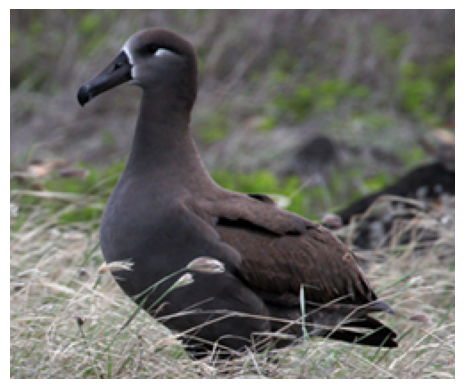

In [8]:
showImage(10)

## Model
### EfficientNet_B1_V2

In [9]:
import torch
import torch.nn as nn
from torchvision import models

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model = models.efficientnet_b1(weights="DEFAULT")

In [12]:
num_params = sum(param.numel() for param in model.parameters())
print(f"Total number of parameters in model: {num_params}")

Total number of parameters in model: 7794184


In [13]:
# printing the model
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
# number of inputs in last layer
num_ftrs = model.classifier[1].in_features

model.classifier[1] = nn.Linear(num_ftrs, 200)

# printing the last layer : classifier
model.classifier

model = model.to(device)

### Loading dataset in torch dataloader

In [15]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

In [16]:
transform = transforms.Compose(
    [
        transforms.Resize((244,244)),
        transforms.ToTensor()
    ]
)

In [17]:
class CUBDataset(Dataset):
    def __init__(self, image_id, id_to_url, image_class_labels, transform):
        self.x = [id_to_url[x] for x in image_id]
        self.y = [image_class_labels[x] for x in image_id]
        self.n_samples = len(image_id)
        self.transform = transform
    
    def __getitem__(self, index):
        img = Image.open(self.x[index])
        img = transforms.Grayscale(num_output_channels=3)(img) if img.mode != "RGB" else img
        img = self.transform(img)
        return img, self.y[index]
    
    def __len__(self):
        return self.n_samples

In [18]:
dataset_train = CUBDataset(
    image_id=image_train,
    id_to_url=image,
    image_class_labels=image_class_labels,
    transform=transform
)
dataset_test = CUBDataset(
    image_id=image_test,
    id_to_url=image,
    image_class_labels=image_class_labels,
    transform=transform
)

In [24]:
dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=1,
    shuffle=False
)
dataloader_test = DataLoader(
    dataset=dataset_test,
    batch_size=1,
    shuffle=False
)

In [20]:
print(len(dataloader_train))

5994


In [21]:
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=learning_rate
)

In [22]:
n_total_steps = len(dataloader_train)
num_epoch = 2
print("Start")
for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(dataloader_train):
        if i >= 5900: 
            continue
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%100 == 0: 
            print(f"Epoch {epoch+1}/{num_epoch}, Step {i+1}/{n_total_steps}, Loss {loss.item():.4f}")
    print()

Start


Epoch 1/2, Step 100/5994, Loss 0.3676
Epoch 1/2, Step 200/5994, Loss 0.0000
Epoch 1/2, Step 300/5994, Loss 0.0000
Epoch 1/2, Step 400/5994, Loss 0.0001
Epoch 1/2, Step 500/5994, Loss 0.0000
Epoch 1/2, Step 600/5994, Loss 0.0000
Epoch 1/2, Step 700/5994, Loss 0.0196
Epoch 1/2, Step 800/5994, Loss 0.0000
Epoch 1/2, Step 900/5994, Loss 0.0000
Epoch 1/2, Step 1000/5994, Loss 11.5199
Epoch 1/2, Step 1100/5994, Loss 0.1707
Epoch 1/2, Step 1200/5994, Loss 0.0000
Epoch 1/2, Step 1300/5994, Loss 5.0766
Epoch 1/2, Step 1400/5994, Loss 0.0000
Epoch 1/2, Step 1500/5994, Loss 0.0000
Epoch 1/2, Step 1600/5994, Loss 0.0229
Epoch 1/2, Step 1700/5994, Loss 0.0000
Epoch 1/2, Step 1800/5994, Loss 0.0000
Epoch 1/2, Step 1900/5994, Loss 0.0015
Epoch 1/2, Step 2000/5994, Loss 0.0000
Epoch 1/2, Step 2100/5994, Loss 0.0000
Epoch 1/2, Step 2200/5994, Loss 0.1087
Epoch 1/2, Step 2300/5994, Loss 0.0008
Epoch 1/2, Step 2400/5994, Loss 0.0000
Epoch 1/2, Step 2500/5994, Loss 0.0349
Epoch 1/2, Step 2600/5994, Loss 0

In [39]:
import torch.nn.functional as F

n_total_steps = len(dataloader_train)
num_epoch = 2
print("Start")
for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(dataloader_train):
        if i >= 5900: 
            continue
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        outputs = F.softmax(outputs, dim=1)
        max_probs, max_indices = torch.max(outputs, dim=1)


        print(max_indices)

Start
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
tensor([197], device='cuda:0')
te

KeyboardInterrupt: 